In [1]:
import torch
from datasets import load_mnist, get_observation_pixels
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

BATCH_SIZE = 100
train_loader, test_loader, val_loader = load_mnist(BATCH_SIZE)

from config import load_config, get_model_name
config = load_config("vq_vae")

model_name = get_model_name(config)

In [2]:
from models import VQVAE
import pytorch_lightning as pl
from trainers import BaseModule

class VAETrainer(BaseModule):
    def __init__(self, num_embeddings, embedding_dim):
        model = VQVAE(num_embeddings, embedding_dim)
        super(VAETrainer, self).__init__(model)
        self.save_hyperparameters()
        
    def forward(self, x, x_cond, y):
        return self.model(x)
    
    def step(self, batch, batch_idx, mode = 'train'):
        x, x_cond, y = batch
        x_hat, quantized, latent, embedding_indices = self(x, x_cond, y)
        loss = self.model.loss(latent, quantized, x_hat, x)
        self.log_dict({f"{mode}_{key}": val.item() for key, val in loss.items()}, sync_dist=True, prog_bar=True)
        return loss['loss']
    
    def decode(self, z):
        return self.model.decode(z)
    
    def load_model_checkpoint(model_name):
        path = ('checkpoints/' + model_name + '.ckpt')
        return VAETrainer.load_from_checkpoint(path)
    

In [3]:
model = VAETrainer(**config['model_params'])

from trainers import SuperTrainer
trainer = SuperTrainer(**config['trainer_params'], model_name=model_name)
trainer.fit(model, train_loader, val_loader)
#save
trainer.save_model_checkpoint()

/Home/siv34/edzak2974/.conda/envs/pytorch_masters/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch_masters/li ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Home/siv34/edzak2974/.conda/envs/pytorch_masters/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch_masters/li ...
  rank_zero_warn(
You are using a CUDA device ('A100-S

Epoch 49: 100%|██████████| 600/600 [00:08<00:00, 68.18it/s, v_num=2, train_loss=0.0427, train_recon_loss=0.0032, train_vq_loss=0.0395, train_commitment_loss=0.0316, train_embeddding_loss=0.0316, val_loss=0.043, val_recon_loss=0.00359, val_vq_loss=0.0394, val_commitment_loss=0.0315, val_embeddding_loss=0.0315]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 600/600 [00:08<00:00, 68.17it/s, v_num=2, train_loss=0.0427, train_recon_loss=0.0032, train_vq_loss=0.0395, train_commitment_loss=0.0316, train_embeddding_loss=0.0316, val_loss=0.043, val_recon_loss=0.00359, val_vq_loss=0.0394, val_commitment_loss=0.0315, val_embeddding_loss=0.0315]


torch.Size([100, 1, 28, 28])


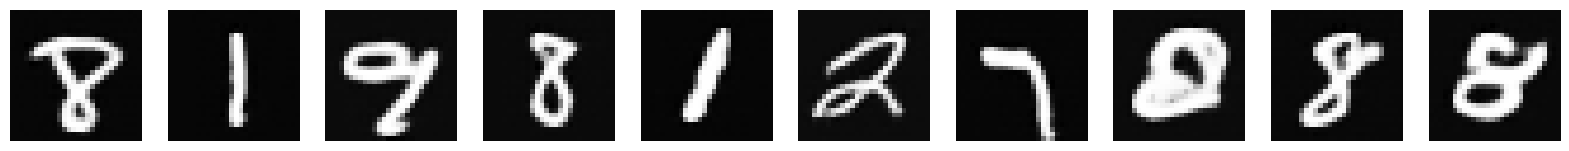

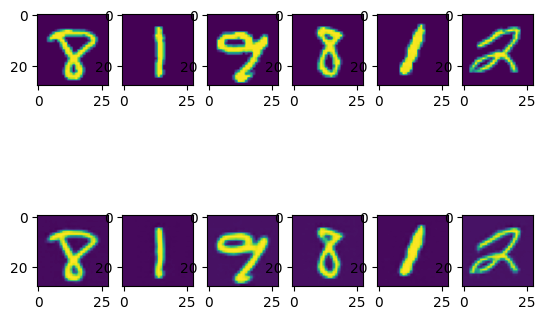

In [4]:
model = VAETrainer.load_model_checkpoint(model_name)

model.eval()

from plotting import plot_samples_with_reconstruction
# plot some samples and their reconstructions

x, _, _ = next(iter(test_loader))

_, _, _, indices = model.model(x)

res = model.model.reconstruct_from_indices(indices)

print(res.shape)

# plot some of the reconstructions

from matplotlib import pyplot as plt
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(res[i, 0, :, :].detach().numpy(), cmap='gray')
    plt.axis('off')
plt.show()




plot_samples_with_reconstruction(model, next(iter(test_loader)))
